# https://distill.pub/2020/growing-ca/

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision
import random
import requests
import io

%matplotlib inline

In [2]:
torch.__version__

'1.2.0'

In [3]:
device='cuda:0'

In [4]:
class Perception(nn.Module):
    def __init__(self, learnable=False, channels=16):
        super().__init__()
        sobel_x = (torch.tensor([[-1, 0, +1],
                                 [-2, 0, +2],
                                 [-1, 0, +1]]).float() / 8)[None, None, ...].repeat(channels, channels, 1, 1)
        sobel_y = (torch.tensor([[-1, -2, -1],
                                 [0, 0, 0],
                                 [-1, -2, -1]]).float() / 8)[None, None, ...].repeat(channels, channels, 1, 1)
        idt = (torch.tensor([[0, 0, 0],
                             [0, 1, 0],
                             [0, 0, 0]]).float())[None, None, ...].repeat(channels, channels, 1, 1)

        self.sobel_x = nn.Conv2d(16, 16, 3, padding=1, bias=False)#nn.Parameter(sobel_x, requires_grad=False)
        self.sobel_y = nn.Conv2d(16, 16, 3, padding=1, bias=False)#nn.Parameter(sobel_y, requires_grad=False)
        self.identity = nn.Conv2d(16, 16, 3, padding=1, bias=False)#nn.Parameter(idt, requires_grad=False)
        
        self.sobel_x.weight = nn.Parameter(sobel_x)
        self.sobel_y.weight = nn.Parameter(sobel_y)
        self.identity.weight = nn.Parameter(idt)


    def forward(self, state_grid, angle=0.0):
        c, s = np.cos(angle), np.sin(angle)
        grad_x = self.sobel_x(state_grid) #F.conv2d(state_grid, self.sobel_x, padding=1)
        grad_y = self.sobel_y(state_grid) #F.conv2d(state_grid, self.sobel_y, padding=1)
        #idt = self.identity(state_grid) #F.conv2d(state_grid, self.identity, padding=1)
        perception_grid = torch.cat([state_grid, c * grad_x - s * grad_y, 
                                     s * grad_x - c * grad_y],  dim=1)
        return perception_grid

class Policy(nn.Module):
    def __init__(self, state_dim=16, interm_dim=128, use_embedding=True, kernel=3, padding=1):
        super().__init__()
        dim = state_dim * 3
        if use_embedding:
            dim += 1
        self.conv1 = nn.Conv2d(dim, interm_dim, kernel, padding=padding)
#                       nn.ReLU(),
#                       nn.Conv2d(interm_dim, interm_dim, kernel, padding=padding),
#                       nn.ReLU(),
#                       nn.Conv2d(interm_dim, interm_dim, kernel, padding=padding)]
        #self.conv1 = nn.Sequential(*self.conv1)
        self.conv2 = nn.Conv2d(interm_dim, state_dim, kernel, padding=padding)
        nn.init.constant_(self.conv2.weight, 0.)
        nn.init.constant_(self.conv2.bias, 0.)
        
    def forward(self, state):
        interm = self.conv1(state)
        interm = nn.ReLU()(interm)
        return self.conv2(interm)
    

class Embedder(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedder = nn.Sequential(*[nn.Conv2d(4, 16, 3),
                                       nn.ReLU(),
                                       nn.Conv2d(16, 16, 3),
                                       nn.ReLU(),
                                       nn.Conv2d(16, 1, 3)])
    
    def forward(self, img):
        return nn.AdaptiveAvgPool2d((1, 1))(self.embedder(img))
    

def stochastic_update_mask(ds_grid, prob=0.5):
    # Generate mask for zero out a random fraction of the updates.
    bern = torch.distributions.Bernoulli(prob)
    rand_mask = bern.sample_n(ds_grid.shape[2] * ds_grid.shape[3]).view(ds_grid.shape[2:]).float().to(ds_grid.device)
    return rand_mask

def alive_mask(state_grid, thr=0.1):
    # Take the alpha channel as the measure of “life”.
    alive = (state_grid[:, 4, :, :].clamp(0, 1) > thr).float().unsqueeze(1)#.repeat(1, 16, 1, 1)
    return alive


In [5]:
class StateGridSet(Dataset):
    def __init__(self, target, use_coords=False, batch_size=10, random_spawn=True):
        self.target = target
        self.use_coords = use_coords
        self.batch_size = batch_size
        self.random_spawn = random_spawn
        
    def __len__(self):
        return self.batch_size
        
    def __getitem__(self, idx):
        state_grid = torch.zeros((16, self.target.shape[-2], self.target.shape[-1]), 
                                  requires_grad=False, device=self.target.device)
        if self.random_spawn:
            center = random.randint(int(0.2 * (self.target.shape[-2] - 1)),
                                    int(0.8 * (self.target.shape[-2] - 1)))
        else:
            center = state_grid.shape[2] // 2
        state_grid[4:, center, center] += torch.ones_like(state_grid[4:, center, center])
        state_grid[4, center, center] = torch.ones_like(state_grid[4, center, center])
        
        if self.use_coords:
            xv, yv = torch.meshgrid([torch.linspace(-1, 1, steps=128),
                         torch.linspace(-1, 1, steps=128)])
            state_grid[-1] = xv
            state_grid[-2] = yv
        
        return state_grid, self.target


In [6]:
def load_image(url, max_size=128):
    r = requests.get(url)
    img = Image.open(io.BytesIO(r.content))
    img.thumbnail((max_size, max_size), Image.ANTIALIAS)
    img = np.float32(img) / 255.
    # premultiply RGB by Alpha
    img[..., :3] *= img[..., 3:]
    return img

def load_emoji(emoji):
    code = hex(ord(emoji))[2:].lower()
    url = 'https://github.com/googlefonts/noto-emoji/raw/master/png/128/emoji_u%s.png'%code
    return load_image(url)



tensor(1., device='cuda:0') tensor(-1., device='cuda:0') tensor(-0.6186, device='cuda:0')


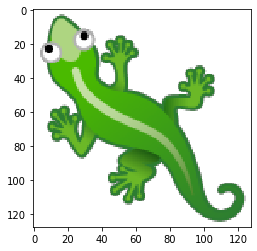

In [7]:
img = load_emoji(emoji='🦎')
img = torchvision.transforms.ToTensor()(img)
img = torchvision.transforms.Normalize(tuple(0.5 for _ in range(img.shape[0])),
                                          tuple(0.5 for _ in range(img.shape[0])))(img)
img = img.to(device)
print(img.max(), img.min(), img.mean())
plt.imshow((img.cpu().permute(1, 2, 0).data.numpy() + 1.) / 2.)

In [8]:
policy = Policy(use_embedding=False, kernel=1, padding=0).to(device)
perception = Perception(learnable=False, channels=16).to(device)
#embedder = Embedder().to(device)
optim = torch.optim.Adam(list(policy.parameters()) + list(perception.parameters()), lr=2e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, 100, gamma=0.7)
loss_fn = nn.MSELoss()

In [9]:
batch_size = 4
dset = StateGridSet(img, use_coords=True, batch_size=batch_size, random_spawn=False)
dset_test = StateGridSet(img, use_coords=True, batch_size=1, random_spawn=False)
dloader = DataLoader(dset, batch_size=batch_size)
dloader_test = DataLoader(dset, batch_size=1)

In [10]:
xv, yv = torch.meshgrid([torch.linspace(-1, 1, steps=128),
             torch.linspace(-1, 1, steps=128)])

for step in range(2000):
    loss_value = 0
    n_steps = random.randint(100, 150)
    split_rate = random.randint(30, 40)
    for state_grid, target in dloader:
        for k in range(n_steps):
            alive_pre = alive_mask((state_grid + 1.) / 2., thr=0.1)
            perception_grid = perception(state_grid)
            ds_grid = policy(perception_grid)
            mask = stochastic_update_mask(ds_grid, prob=0.9)[None, None]
            state_grid = state_grid + ds_grid * mask
            alive_post = alive_mask((state_grid + 1.) / 2., thr=0.1)
            state_grid = state_grid * (alive_post.bool() & alive_pre.bool()).float()
            
            if dset.use_coords:
                state_grid[:, -1, ...] = xv[None, :, :]
                state_grid[:, -2, ...] = yv[None, :, :]
            
            if k % split_rate == 0:
                loss_value = loss_fn(target[:, :4, ...], state_grid[:, :4, ...])
                optim.zero_grad()
                loss_value.backward()
                optim.step()
                state_grid = state_grid.detach()
                #idx_to_new = random.randint(0, dset.batch_size - 1)
                #state_grid[idx_to_new] = next(iter(dloader))[0][idx_to_new]
    if k % split_rate == 0:
        pass
    else:
        loss_value = loss_fn(target[:, :4, ...], state_grid[:, :4, ...])
        optim.zero_grad()
        loss_value.backward()
        optim.step()
    scheduler.step()
    print(f'{loss_value.item():.2f}, {n_steps} steps, {split_rate} split rate, {step} epoch')
plt.imshow((((state_grid[0, :3, ...] + 1.) / 2.).clamp(0, 1).cpu().permute(1, 2, 0).data.numpy() + 1.) / 2.)

/opt/conda/lib/python3.7/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


38452.95, 109 steps, 35 split rate, 0 epoch
1.66, 119 steps, 32 split rate, 1 epoch
0.85, 140 steps, 36 split rate, 2 epoch
0.73, 121 steps, 35 split rate, 3 epoch
0.69, 118 steps, 36 split rate, 4 epoch
0.67, 132 steps, 40 split rate, 5 epoch
0.66, 100 steps, 38 split rate, 6 epoch
0.66, 117 steps, 33 split rate, 7 epoch


KeyboardInterrupt: 

In [ ]:
target.shape

In [ ]:
imgs = []
topil = torchvision.transforms.ToPILImage()
with torch.no_grad():
    for state_grid, _ in dloader_test:
        for k in range(150):
            imgs.append(topil(state_grid[0, :4, ...].cpu()))
            alive_pre = alive_mask((state_grid + 1.) / 2., thr=0.1)
            perception_grid = perception(state_grid)
            ds_grid = policy(perception_grid)
            mask = stochastic_update_mask(ds_grid, prob=0.1)[None, None]
            state_grid = state_grid + ds_grid * mask
            alive_post = alive_mask((state_grid + 1.) / 2., thr=0.1)
            state_grid = state_grid * (alive_post.bool() & alive_pre.bool()).float()
        break

In [ ]:
imgs[0].save('/home/gleb/Downloads/out.gif', save_all=True, append_images=imgs[1:])

In [ ]:
plt.imshow((((state_grid[0, :3, ...] + 1.) / 2.).clamp(0, 1).cpu().permute(1, 2, 0).data.numpy() + 1.) / 2.)

In [ ]:
plt.imshow(perception(target[:, :4])[0, :4].cpu().permute(1, 2, 0).data.numpy())

In [ ]:
plt.imshow((perception(state_grid)[0, 16:19].cpu().permute(1, 2, 0).data.numpy() + 1.) / 2.)

In [ ]:
plt.imshow(perception_grid[0, :3].permute(1, 2, 0).cpu().data.numpy())

In [ ]:
ds_grid.shape

In [ ]:
mask = stochastic_update_mask(ds_grid, prob=0.1)[None, None]
plt.imshow((target * mask)[0].permute(1, 2, 0)[:, :, :3].cpu().data.numpy())

In [ ]:
plt.imshow((perception_grid[0, 32:35].permute(1, 2, 0).cpu().data.numpy() + 1) / 2)

In [ ]:
(torch.ones_like(state_grid) * (1 - alive_post)).shape

In [ ]:
plt.imshow(state_grid[0, 4, ...].cpu().data.numpy())

In [ ]:
plt.imshow(alive_mask(state_grid, thr=0.1).cpu().data.numpy()[0][0])

In [ ]:
alive_post.sum()

In [ ]:
target[:, :3].max()

In [ ]:
plt.imshow(((state_grid[0, :3, ...]).cpu().permute(1, 2, 0).data.numpy() + 1.) / 2.)

In [ ]:
plt.imshow((target[0].cpu().permute(1, 2, 0).data.numpy() + 1) / 2)